In [3]:
import torch
print(torch.__version__, torch.cuda.is_available())

1.7.1+cu110 True


In [2]:
import torchvision
print(torchvision.__version__)

0.8.2+cu110


## Import Libraries

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
from detectron2.structures import BoxMode

# Standard Category
from enum import Enum

class FoodClass(Enum):
    banana = 0
    apple = 1
    carrot = 2
    tomato = 3
    milk = 4

## Capture images in data set
## Works only for bounding box annotation
def get_imageset_dicts(img_dir, annotation_json):
    json_file = os.path.join(img_dir, annotation_json)
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        # print ("Processing file: %s"%v["filename"])
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []

        ## For bounding polygon annotation
        # for _, anno in annos.items():
        #     assert not anno["shape_attributes"]
        #     assert not anno["region_attributes"]
        #     shape_attr = anno["shape_attributes"]
        #     px = shape_attr["all_points_x"]
        #     py = shape_attr["all_points_y"]
        #     poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        #     poly = [p for x in poly for p in x]

        #     reg_attr = anno["region_attributes"]
        #     f_class = FoodClass[reg_attr["food-class"]]
        #     obj = {
        #         "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
        #         "bbox_mode": BoxMode.XYXY_ABS,
        #         "segmentation": [poly],
        #         "category_id": f_class.value,
        #     }
        #     objs.append(obj)
        
        ## Works only for bounding box annotation
        for anno in annos:
            assert anno["shape_attributes"]
            assert anno["region_attributes"]
            shape_attr = anno["shape_attributes"]
            px = shape_attr["x"]
            py = shape_attr["y"]
            pw = shape_attr["width"]
            ph = shape_attr["height"]
            poly = [(px, py), (px+pw, py), (px+pw, py+ph), (px, py+ph)]

            reg_attr = anno["region_attributes"]
            f_class = FoodClass[reg_attr["food-class"]]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": f_class.value,
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:

## Define the paths and register the dataset
dataset = "ann_test_1"
dataset_ref = "/users/pgrad/hegdeb/IoT/fidarProj/fidar/data/processed"
via_json = "via_regions.json"
proj_path = "/users/pgrad/hegdeb/IoT/fidarProj/fidar/"

# DatasetCatalog.remove(dataset)
DatasetCatalog.register(dataset, lambda:get_imageset_dicts(os.path.join(dataset_ref, dataset), via_json))
MetadataCatalog.get(dataset).set(thing_classes=[cat.name for cat in FoodClass])



namespace(name='ann_test_1',
          thing_classes=['banana', 'apple', 'carrot', 'tomato', 'milk'])

In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances(dataset + "_coco", {}, "coco_regions.json", dataset_ref)

In [8]:
dataset_metadata = MetadataCatalog.get(dataset)
dataset_metadata_coco = MetadataCatalog.get(dataset + "_coco")

## Visualize the data

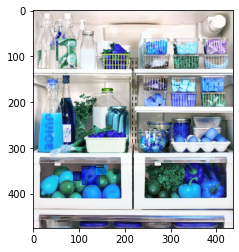

In [9]:
from matplotlib import pyplot as plt
dataset_dicts = get_imageset_dicts(os.path.join(dataset_ref, dataset), via_json)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

## Fine Tune the model


In [10]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (dataset+"_coco",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(FoodClass)
cfg.OUTPUT_DIR = os.path.join("/users/pgrad/hegdeb/IoT/fidarProj/fidar/", "models", dataset+"_coco")

In [13]:
print("Results will be in %s"%cfg.OUTPUT_DIR)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

Results will be in /users/pgrad/hegdeb/IoT/fidarProj/fidar/models/ann_test_1


In [14]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

m): FrozenBatchNorm2d(num_features=64, eps=1e-05)
          )
          (conv2): Conv2d(
            64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
          )
          (conv3): Conv2d(
            64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
          )
        )
        (1): BottleneckBlock(
          (conv1): Conv2d(
            256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
          )
          (conv2): Conv2d(
            64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
          )
          (conv3): Conv2d(
            64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
          )
      

In [ ]:
cfg.DATASETS.TRAIN = (dataset,)
cfg.OUTPUT_DIR = os.path.join("/users/pgrad/hegdeb/IoT/fidarProj/fidar/", "models", dataset)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [40]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [15]:
# cfg already contains everything we've set previously. Now we changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [1]:

from detectron2.utils.visualizer import ColorMode

# im = cv2.imread("/users/pgrad/hegdeb/IoT/fidarProj/fidar/data/raw/sample_img/test1.png")
im = cv2.imread("/users/pgrad/hegdeb/IoT/fidarProj/fidar/data/raw/ann_test_1/fi13.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                metadata=dataset_metadata, 
                scale=0.5
            #    , 
            #   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

NameError: name 'cv2' is not defined

In [25]:
print(outputs)

{'instances': Instances(num_instances=0, image_height=877, image_width=1170, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 877, 1170), dtype=torch.uint8)])}
